In [ ]:
!pip install prince
!pip install pyod

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.8/417.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

# sklearn
from sklearn.cluster import KMeans
from sklearn.preprocessing import PowerTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, accuracy_score, classification_report

from pyod.models.ecod import ECOD
from yellowbrick.cluster import KElbowVisualizer

import lightgbm as lgb
import prince

Useful funtions

In [ ]:
def get_pca_2d(df, predict):

    pca_2d_object = prince.PCA(
    n_components=2,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_2d_object.fit(df)

    df_pca_2d = pca_2d_object.transform(df)
    df_pca_2d.columns = ["comp1", "comp2"]
    df_pca_2d["cluster"] = predict

    return pca_2d_object, df_pca_2d



def get_pca_3d(df, predict):

    pca_3d_object = prince.PCA(
    n_components=3,
    n_iter=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
    )

    pca_3d_object.fit(df)

    df_pca_3d = pca_3d_object.transform(df)
    df_pca_3d.columns = ["comp1", "comp2", "comp3"]
    df_pca_3d["cluster"] = predict

    return pca_3d_object, df_pca_3d



def plot_pca_3d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter_3d(df,
                        x='comp1',
                        y='comp2',
                        z='comp3',
                        color='cluster',
                        template="plotly",

                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 4,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 1000,
                                height = 800,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            zaxis=dict(title = 'comp3', titlefont_color = 'black')),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


def plot_pca_2d(df, title = "PCA Space", opacity=0.8, width_line = 0.1):

    df = df.astype({"cluster": "object"})
    df = df.sort_values("cluster")

    fig = px.scatter(df,
                        x='comp1',
                        y='comp2',
                        color='cluster',
                        template="plotly",
                        # symbol = "cluster",

                        color_discrete_sequence=px.colors.qualitative.Vivid,
                        title=title).update_traces(
                            # mode = 'markers',
                            marker={
                                "size": 8,
                                "opacity": opacity,
                                # "symbol" : "diamond",
                                "line": {
                                    "width": width_line,
                                    "color": "black",
                                }
                            }
                        ).update_layout(
                                width = 800,
                                height = 700,
                                autosize = False,
                                showlegend = True,
                                legend=dict(title_font_family="Times New Roman",
                                            font=dict(size= 20)),
                                scene = dict(xaxis=dict(title = 'comp1', titlefont_color = 'black'),
                                            yaxis=dict(title = 'comp2', titlefont_color = 'black'),
                                            ),
                                font = dict(family = "Gilroy", color  = 'black', size = 15))


    fig.show()


Get Data

In [ ]:
df = pd.read_csv("train.csv", sep = ";")
df = df.iloc[:, 0:8]


In [ ]:
df_embedding = pd.read_csv("embedding_train.csv", sep = ",")

Outliers

In [ ]:
from pyod.models.ecod import ECOD

# Drop rows with NaN and keep only numeric columns
df_embedding_clean = df_embedding.dropna()
df_embedding_clean = df_embedding_clean.select_dtypes(include=['number'])

# Fit ECOD
clf = ECOD()
clf.fit(df_embedding_clean)

# Predict outliers
out = clf.predict(df_embedding_clean)

# Assign predictions
df_embedding = df_embedding.copy()
df_embedding.loc[df_embedding_clean.index, "outliers"] = out

# Create filtered outputs
df_embedding_no_out = df_embedding[df_embedding["outliers"] == 0].drop("outliers", axis=1)
df_embedding_with_out = df_embedding.drop("outliers", axis=1)


In [ ]:
df_embedding_no_out.shape

(1207, 384)

In [ ]:
df_embedding_with_out.shape

(1343, 384)

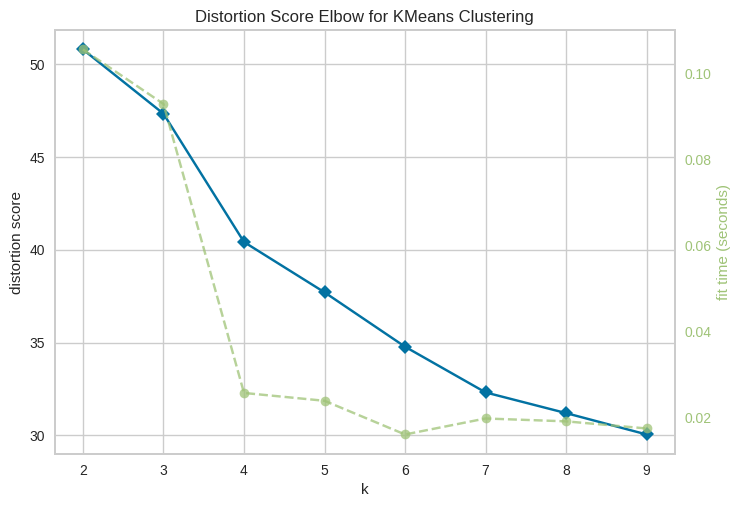

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Drop rows with NaN values before fitting
df_embedding_clean = df_embedding_with_out.dropna()

# Fit the visualizer with cleaned data
km = KMeans(init="k-means++", random_state=0, n_init="auto")
visualizer = KElbowVisualizer(km, k=(2,10), locate_elbow=False)
visualizer.fit(df_embedding_clean)
visualizer.show()


Best Number of Clusters

![Alt text](kpropotype_no_out.png)

The best number is 5-6

Modeling

In [ ]:
n_clusters = 5

In [ ]:
clusters = KMeans(n_clusters=n_clusters, init = "k-means++").fit(df_embedding_no_out)
print(clusters.inertia_)
clusters_predict = clusters.predict(df_embedding_no_out)

27.79031789078432


Evaluation

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

"""
The Davies Bouldin index is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
The minimum value of the DB Index is 0, whereas a smaller value (closer to 0) represents a better model that produces better clusters.
"""
print(f"Davies bouldin score: {davies_bouldin_score(df_embedding_no_out,clusters_predict)}")

"""
Calinski Harabaz Index -> Variance Ratio Criterion.
Calinski Harabaz Index is defined as the ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
The higher the index the more separable the clusters.
"""
print(f"Calinski Score: {calinski_harabasz_score(df_embedding_no_out,clusters_predict)}")


"""
The silhouette score is a metric used to calculate the goodness of fit of a clustering algorithm, but can also be used as a method for determining an optimal value of k (see here for more).
Its value ranges from -1 to 1.
A value of 0 indicates clusters are overlapping and either the data or the value of k is incorrect.
1 is the ideal value and indicates that clusters are very dense and nicely separated.
"""
print(f"Silhouette Score: {silhouette_score(df_embedding_no_out,clusters_predict)}")

Davies bouldin score: 1.6818640217781329
Calinski Score: 228.2619988576269
Silhouette Score: 0.24752390588349896


In [ ]:
pca_3d_object, df_pca_3d = get_pca_3d(df_embedding_no_out, clusters_predict)
plot_pca_3d(df_pca_3d, title = "PCA Space", opacity=1, width_line = 0.1)
print("The variability is :", pca_3d_object.eigenvalues_summary)

The variability is :           eigenvalue % of variance % of variance (cumulative)
component                                                    
0             72.641        18.92%                     18.92%
1             52.901        13.78%                     32.69%
2             37.219         9.69%                     42.39%


![Alt text](img/embedding1.png)

In [ ]:
pca_2d_object, df_pca_2d = get_pca_2d(df_embedding_no_out, clusters_predict)
plot_pca_2d(df_pca_2d, title = "PCA Space", opacity=1, width_line = 0.2)


![Alt text](img/embedding2.png)

t-SNE   3D

In [ ]:
sampling_data = df_embedding_no_out.sample(frac=0.5, replace=True, random_state=1)
sampling_clusters = pd.DataFrame(clusters_predict).sample(frac=0.5, replace=True, random_state=1)[0].values

df_tsne_3d = TSNE(
                  n_components=3,
                  learning_rate=500,
                  init='random',
                  perplexity=30,
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_3d = pd.DataFrame(df_tsne_3d, columns=["comp1", "comp2",'comp3'])
df_tsne_3d["cluster"] = sampling_clusters
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1, width_line = 0.1)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



![Alt text](img/embedding3.png)

In [ ]:
plot_pca_3d(df_tsne_3d, title = "T-SNE Space", opacity=1,width_line = 0.1)

t-SNE 2D

In [ ]:
df_tsne_2d = TSNE(
                  n_components=2,
                  learning_rate=500,
                  init='random',
                  perplexity=30,
                  n_iter = 5000).fit_transform(sampling_data)

df_tsne_2d = pd.DataFrame(df_tsne_2d, columns=["comp1", "comp2"])
df_tsne_2d["cluster"] = sampling_clusters

plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



![Alt text](img/embedding4.png)

In [ ]:
plot_pca_2d(df_tsne_2d, title = "PCA Space", opacity=1, width_line = 0.5)


<h1> Explanations </h1>

In [ ]:
from pyod.models.ecod import ECOD

# Fit ECOD model
clf = ECOD()
clf.fit(df_embedding_clean)

# Predict outliers (0 = inlier, 1 = outlier)
out = clf.predict(df_embedding_clean)

# Add outliers column to cleaned DataFrame
df_embedding_clean = df_embedding_clean.copy()
df_embedding_clean["outliers"] = out

# Remove rows identified as outliers
df_no_outliers = df_embedding_clean[df_embedding_clean["outliers"] == 0].drop("outliers", axis=1)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97944
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 390
[LightGBM] [Info] Start training from score -2.350961
[LightGBM] [Info] Start training from score -2.133049
[LightGBM] [Info] Start training from score -1.106932
[LightGBM] [Info] Start training from score -1.802588
[LightGBM] [Info] Start training from score -1.235107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

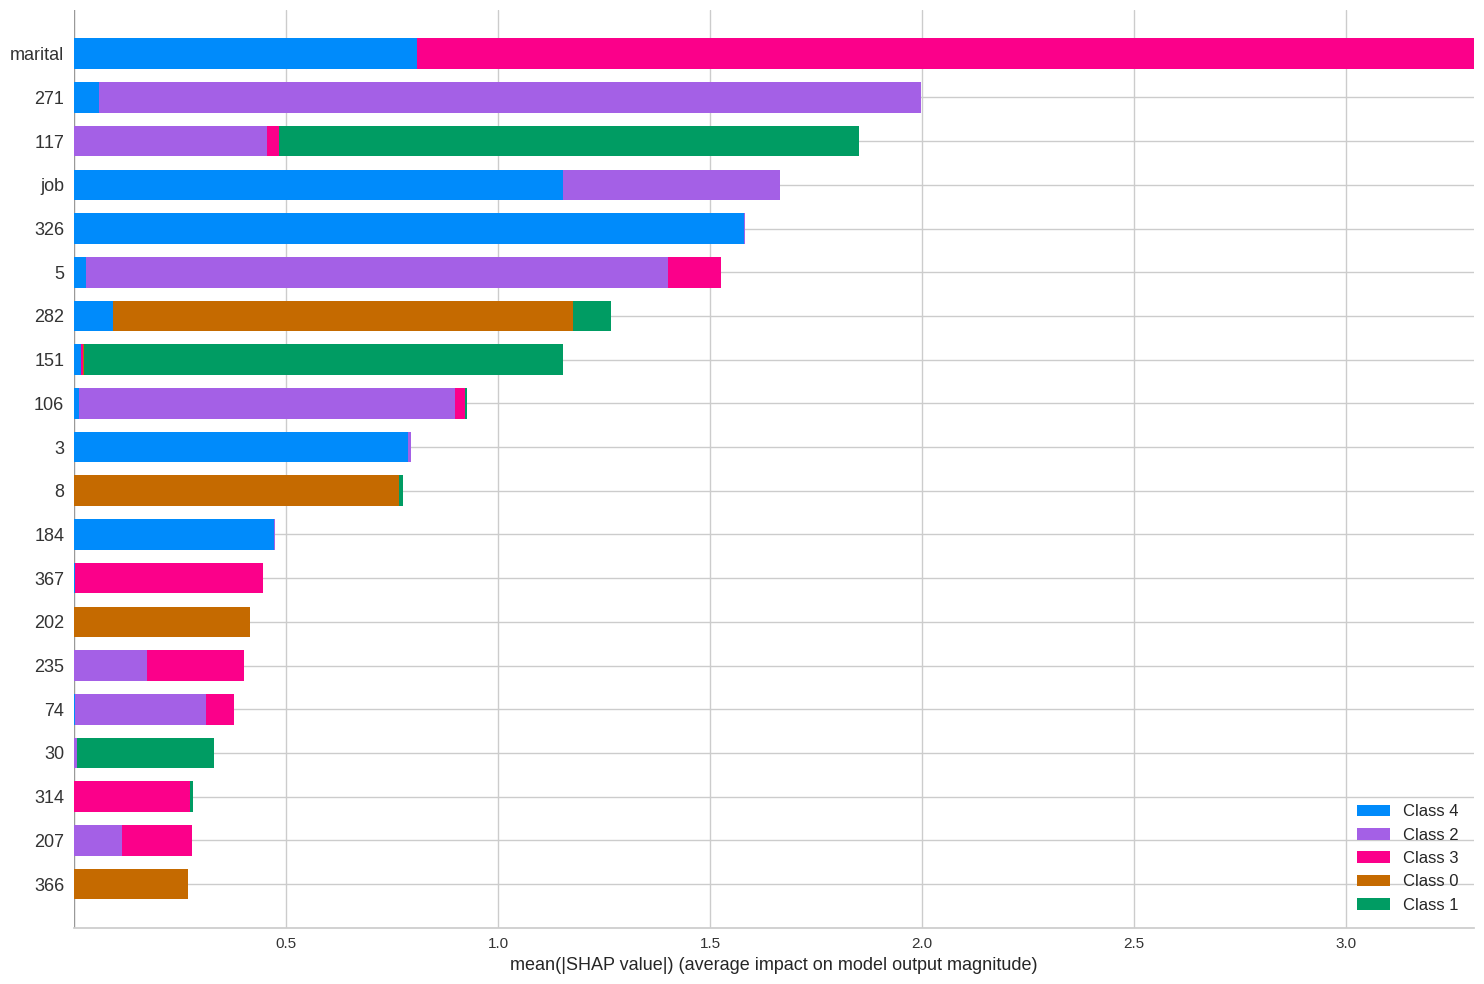

In [ ]:
# Assume `df_original` has all the original categorical columns
# and df_no_outliers only has embeddings

# Join on index to recover the categorical columns
df_no_outliers_full = df_no_outliers.join(df[["job", "marital", "education", "housing", "loan", "default"]])

# Now convert to category safely
for col in ["job", "marital", "education", "housing", "loan", "default"]:
    df_no_outliers_full[col] = df_no_outliers_full[col].astype('category')

# Fit model
clf_km = lgb.LGBMClassifier(colsample_bytree=0.8)
clf_km.fit(X=df_no_outliers_full, y=clusters_predict)

# SHAP
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(df_no_outliers_full)

# Plot
shap.summary_plot(shap_values_km, df_no_outliers_full, plot_type="bar", plot_size=(15, 10))


In [ ]:
# Predict using the correct input
y_pred = clf_km.predict(df_no_outliers_full)

# Evaluate accuracy
accuracy = accuracy_score(clusters_predict, y_pred)
print('Training-set accuracy score: {0:0.4f}'.format(accuracy))
print(classification_report(clusters_predict, y_pred))


Training-set accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       115
           1       1.00      1.00      1.00       143
           2       1.00      1.00      1.00       399
           3       1.00      1.00      1.00       199
           4       1.00      1.00      1.00       351

    accuracy                           1.00      1207
   macro avg       1.00      1.00      1.00      1207
weighted avg       1.00      1.00      1.00      1207



Cluster Info

In [ ]:
# Step 1: Merge original columns back with df_no_outliers using index
df_no_outliers_full = df_no_outliers.join(df[[
    'job', 'marital', 'education', 'housing', 'loan', 'age', 'balance', 'default'
]])

# Step 2: Add cluster predictions
df_no_outliers_full["cluster"] = clusters_predict

# Step 3: Group by and get dominant values per cluster
df_group = df_no_outliers_full.groupby('cluster').agg(
    {
        'job': lambda x: x.value_counts().index[0],
        'marital': lambda x: x.value_counts().index[0],
        'education': lambda x: x.value_counts().index[0],
        'housing': lambda x: x.value_counts().index[0],
        'loan': lambda x: x.value_counts().index[0],
        'age': 'mean',
        'balance': 'mean',
        'default': lambda x: x.value_counts().index[0],
    }
).sort_values("job").reset_index()
print(df_group)

   cluster          job  marital  education housing loan        age  \
0        0       admin.  married  secondary     yes   no  42.182609   
1        3       admin.   single  secondary     yes   no  36.512563   
2        2  blue-collar  married  secondary     yes   no  41.964912   
3        4     services  married  secondary     yes   no  44.712251   
4        1   technician  married  secondary     yes   no  43.923077   

      balance default  
0  887.400000      no  
1  509.979899      no  
2  393.147870      no  
3  612.407407      no  
4  456.216783      no  
